In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install koreanize-matplotlib

import koreanize_matplotlib
%matplotlib inline

In [ ]:
!pip install squarify

In [5]:
import pandas as pd

In [6]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
import datetime

today = datetime.date(2019, 12, 31)

In [7]:
onlinesales_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Onlinesales_info.csv')
marketing_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Marketing_info.csv')
tax_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Tax_info.csv')
customer_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Customer_info.csv')
discount_info = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/Discount_info.csv')

In [8]:
shoppingcart_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/shoppingcart_df.csv', index_col=0)

In [9]:
customer_buyinginfo_df = pd.read_csv('/content/drive/MyDrive/FINAL_Team_Project_git/ML_COMMERCE/data/customer_buyinginfo_df.csv')

rfm_df = customer_buyinginfo_df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]    # +1일
rfm_df.columns = ['CustomerID', 'R', 'F', 'M']
rfm_df

,CustomerID,R,F,M
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


# RFM 분석

- R : 얼마나 최근에 방문했는가
- F : 얼마나 자주 방문했는가
- M : 얼마나 많은 돈을 사용했는가


- 각 요소별 분포 시각화

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

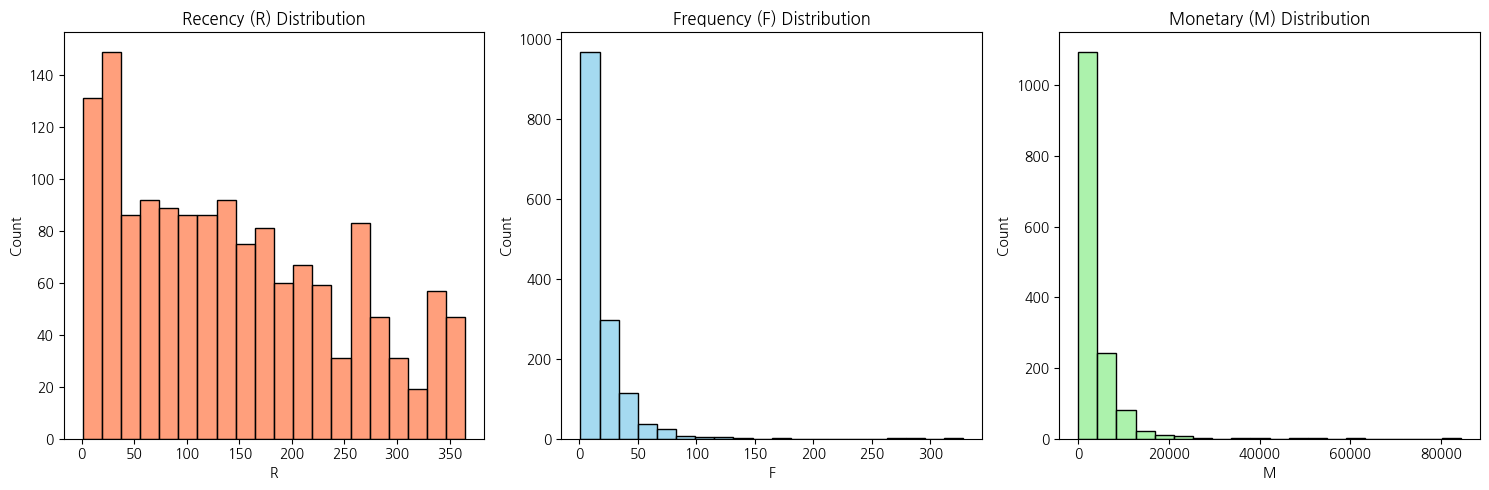

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_df['R'], bins=20, color='coral', edgecolor='black')
plt.title('Recency (R) Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_df['F'], bins=20, color='skyblue', edgecolor='black')
plt.title('Frequency (F) Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_df['M'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Monetary (M) Distribution')

plt.tight_layout()
plt.show()

- --> F와 M은 매우 편향된 경향을 보이는 반면 R은 비교적 고르게 분포하고 있음

---
---
# 1. 매출에 큰 영향을 주는 총주문금액(M)을 기준으로 RFM 재구분
- 매출이 큰데 이탈 고객일 수도 있고, 매출이 적은데 이탈 고객일 수도 있다.
- 두 그룹을 다르게 접근해본다.

## 1-1. 하위 80% M을 기준으로 데이터 분류

In [30]:
percentiles = [0.20, 0.40, 0.60, 0.80, 0.90]
rfm_df['M'].describe(percentiles=percentiles)

count     1468.000000
mean      3460.302548
std       5519.945748
min          6.990000
20%        559.296000
40%       1341.976000
50%       1899.320000
60%       2605.372000
80%       5055.090000
90%       8032.211000
max      84405.830000
Name: M, dtype: float64

In [31]:
rfm_m80_df = rfm_df[rfm_df['M'] <= 5055.090000]
rfm_m80_df

,CustomerID,R,F,M
0,USER_0000,108,1,99.98
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
5,USER_0005,131,3,706.02
...,...,...,...,...
1462,USER_1462,180,2,70.85
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90


In [32]:
# Recency, Frequency, Monetary를 5분위로 나누어 각각에 점수 부여하는 함수 정의 -> 1~5점 부여

def assign_score(series):
    quartiles = pd.qcut(series,
                        q=5,
                        labels=False, # 각 분위를 숫자로 표시
                        duplicates='drop' # 중복 값이 있는 경우 중복 값을 삭제 -> 중복값 처리를 해줘야 동일 값일때 다르게 분류되는 오류를 범하지 않음
                        )

    # Recency에 대한 점수는 작은 값일수록 높은 점수를 가지도록 조정
    if series.name == 'R':
        return 5 - quartiles
    else:
        return quartiles + 1

# RFM 점수 부여
rfm_m80_df['RScore'] = assign_score(rfm_m80_df['R'])
rfm_m80_df['MScore'] = assign_score(rfm_m80_df['M'])
rfm_m80_df['FScore'] = assign_score(rfm_m80_df['F'])

In [33]:
rfm_m80_df

,CustomerID,R,F,M,RScore,MScore,FScore
0,USER_0000,108,1,99.98,4,1,1
2,USER_0002,74,8,1573.49,4,3,3
3,USER_0003,18,11,1421.96,5,3,4
4,USER_0004,108,13,1524.42,4,3,4
5,USER_0005,131,3,706.02,3,2,1
...,...,...,...,...,...,...,...
1462,USER_1462,180,2,70.85,2,1,1
1463,USER_1463,271,3,676.73,1,2,1
1464,USER_1464,88,19,2606.18,4,4,5
1465,USER_1465,195,2,127.90,2,1,1


- RFM 스코어 열 생성

In [34]:
# rfm_score을 합치기 위해 string으로 형 변환
rfm_m80_df['RScore'] = rfm_m80_df['RScore'].astype(str)
rfm_m80_df['FScore'] = rfm_m80_df['FScore'].astype(str)
rfm_m80_df['MScore'] = rfm_m80_df['MScore'].astype(str)

# rfm_score 합치기
rfm_m80_df['RFMScore'] = rfm_m80_df['RScore'] + rfm_m80_df['FScore'] + rfm_m80_df['MScore']
rfm_m80_df

,CustomerID,R,F,M,RScore,MScore,FScore,RFMScore
0,USER_0000,108,1,99.98,4,1,1,411
2,USER_0002,74,8,1573.49,4,3,3,433
3,USER_0003,18,11,1421.96,5,3,4,543
4,USER_0004,108,13,1524.42,4,3,4,443
5,USER_0005,131,3,706.02,3,2,1,312
...,...,...,...,...,...,...,...,...
1462,USER_1462,180,2,70.85,2,1,1,211
1463,USER_1463,271,3,676.73,1,2,1,112
1464,USER_1464,88,19,2606.18,4,4,5,454
1465,USER_1465,195,2,127.90,2,1,1,211


In [ ]:
rfm_m80_df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,1174.0,154.390119,100.653277,1.00,70.00,144.000,227.75,365.00
F,1174.0,10.115843,7.862536,1.00,4.00,8.000,15.00,43.00
M,1174.0,1695.987291,1372.626706,6.99,559.29,1341.115,2604.10,5052.54


In [ ]:
rfm_m80_df.groupby('RScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RScore,,,,,,,,
1,229.0,307.157205,34.573488,258.0,276.0,301.0,340.0,365.0
2,235.0,213.795745,23.269344,174.0,195.0,210.0,230.0,257.0
3,233.0,146.682403,16.210429,119.0,133.0,146.0,159.0,173.0
4,242.0,85.859504,19.369654,51.0,70.0,87.0,103.0,118.0
5,235.0,24.331915,12.058637,1.0,16.0,22.0,33.0,50.0


In [ ]:
rfm_m80_df.groupby('FScore')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FScore,,,,,,,,
1,265.0,1.781132,0.824129,1.0,1.00,2.0,3.00,3.0
2,216.0,5.018519,0.777372,4.0,4.00,5.0,6.00,6.0
3,239.0,8.338912,1.083777,7.0,7.00,8.0,9.00,10.0
4,242.0,13.768595,2.036025,11.0,12.00,14.0,15.00,17.0
5,212.0,23.561321,4.667221,18.0,19.75,23.0,26.25,43.0


In [ ]:
rfm_m80_df.groupby('MScore')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MScore,,,,,,,,
1,235.0,163.622936,120.938505,6.99,50.095,139.930,268.3850,384.09
2,235.0,701.971872,177.977010,384.14,559.300,680.450,853.5850,995.23
3,234.0,1361.443419,240.716806,998.66,1141.440,1341.115,1566.9525,1791.61
4,235.0,2326.336596,349.914934,1791.70,2028.150,2284.340,2603.0300,3001.02
5,235.0,3925.138043,605.363730,3007.00,3389.035,3863.260,4430.9850,5052.54


- Monetary 하위 80%를 5개 그룹으로 구분할 시 기준

In [ ]:
RFM_M80_Group_df = pd.DataFrame({'Group': [1, 2, 3, 4, 5],
                                   'R(day)' : ['258~365', '174~257', '119~173', '51~118', '1~50'],
                                   'F(Count)':['1~3', '4~6', '7~10', '11~17', '18~43'],
                                   'M(USD)' : ['6.99~384.09', '384.14~995.23', '998.66~1791.61', '1791.70~3001.02', '3007.0~5052.54']}).set_index('Group', drop=True)
RFM_M80_Group_df

,R(day),F(Count),M(USD)
Group,,,
1,258~365,1~3,6.99~384.09
2,174~257,4~6,384.14~995.23
3,119~173,7~10,998.66~1791.61
4,51~118,11~17,1791.70~3001.02
5,1~50,18~43,3007.0~5052.54


## 1-2. 상위 20% M을 기준으로 데이터 분류

In [16]:
rfm_m80_upper_df = rfm_df[rfm_df['M'] > 5055.090000]
rfm_m80_upper_df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,294.0,108.962585,99.054241,1.00,33.2500,72.500,158.25,363.00
F,294.0,50.187075,39.841782,4.00,32.0000,39.000,55.00,328.00
M,294.0,10505.561429,9095.965301,5056.79,6361.9325,8038.825,11269.59,84405.83


- --> Monetary 기준으로만 발라내면 R과 F를 기준으로 공통된 성향을 찾기 어렵다.
- --> 구매액이 높은 고객군을 다시 RFM으로 재구분을 한다.
- --> 단, 1회 구매라도 구매금액이 높은 고객이기 때문에, 재유치만 한다면 다시 높은 매출을 창출할 수 있는 잠재고객일 수 있기 때문에 소수의 그룹으로 재분배하는 것도 의미가 있어보인다.

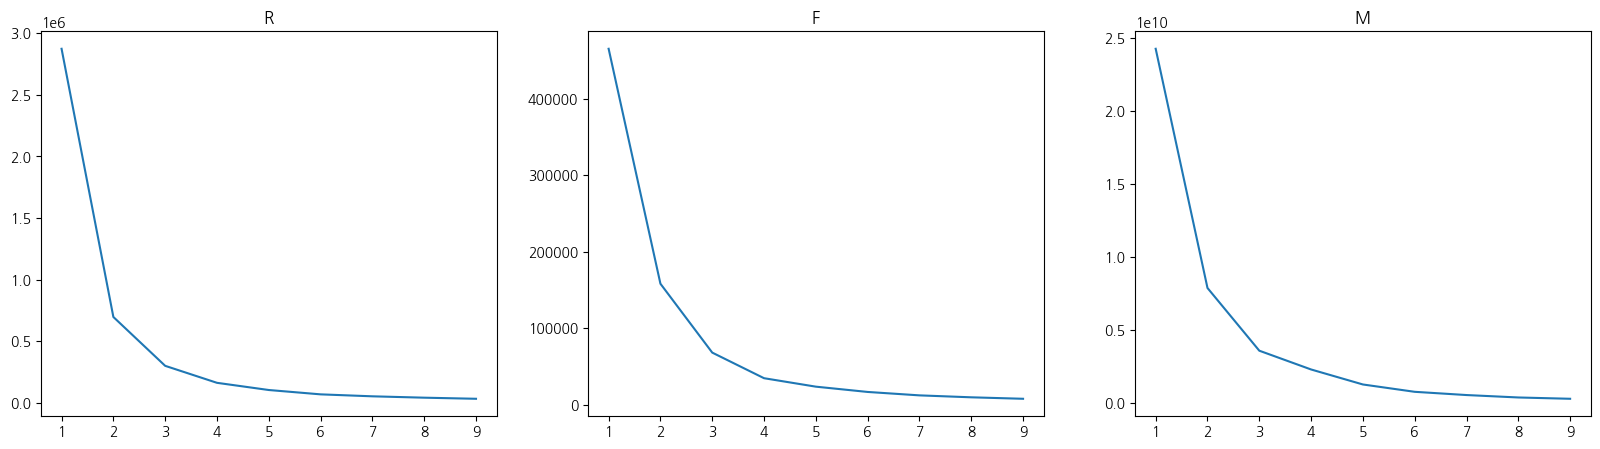

In [ ]:
# Recency kmeans 계산을 위한 elbow point: 엘보우 포인트는 클러스터의 수가 증가함에 따라 클러스터 내 오차 제곱합(SSE: Sum of Squared Errors)이 어떻게 변하는지를 보여줌. 엘보우 포인트는 SSE의 감소율이 급격하게 줄어드는 지점으로, 이 지점에서는 클러스터의 수를 증가시켜도 성능이 크게 향상되지 않는다는 것을 의미
from sklearn.cluster import KMeans

recency_point = {}
frequency_point = {}
monetary_point = {}

rfm_m80_upper_df_recency = rfm_m80_upper_df[['R']].copy()
rfm_m80_upper_df_frequency = rfm_m80_upper_df[['F']].copy()
rfm_m80_upper_df_monetary = rfm_m80_upper_df[['M']].copy()

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_recency)
  rfm_m80_upper_df_recency['cluster'] = kmeans.labels_
  recency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_frequency)
  rfm_m80_upper_df_frequency['cluster'] = kmeans.labels_
  frequency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_monetary)
  rfm_m80_upper_df_monetary['cluster'] = kmeans.labels_
  monetary_point[k] = kmeans.inertia_

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax0 = sns.lineplot(ax=axes[0], x=list(recency_point.keys()), y=list(recency_point.values()))
ax0.set_title('R')

ax1 = sns.lineplot(ax=axes[1], x=list(frequency_point.keys()), y=list(frequency_point.values()))
ax1.set_title('F')

ax2 = sns.lineplot(ax=axes[2], x=list(monetary_point.keys()), y=list(monetary_point.values()))
ax2.set_title('M')
plt.show()

- --> R, F, M 스코어 각각을 이용해서 엘보우 포인트 확인 결과 3개가 가장 적당해보임

In [17]:
# 5개 bins, 5점 기준으로 점수 부여
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["RScore"] = pd.qcut(df_["R"], 3, labels=[3, 2, 1])   # 3이 가장 높은 점수
    df_["FScore"] = pd.qcut(
        df_["F"].rank(method="first"), 3, labels=[1, 2, 3]   # method = "first"는 순위 간 동률을 처리할 때 사용
    )
    df_["MScore"] = pd.qcut(df_["M"], 3, labels=[1, 2, 3])
    df_["RFMScore"] = df_["RScore"].astype(str) + df_["FScore"].astype(str) + df_["MScore"].astype(str)   # RFMScore는 점수들의 str 조합

    return df_

rfm_m80_upper_score_df = get_rfm_scores(rfm_m80_upper_df)
rfm_m80_upper_score_df

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore
1,USER_0001,60,31,15308.13,2,1,3,213
6,USER_0006,190,44,7708.11,1,2,2,122
8,USER_0008,41,37,10807.72,3,2,3,323
9,USER_0009,100,39,5572.17,2,2,1,221
25,USER_0025,41,32,6091.21,3,1,1,311
...,...,...,...,...,...,...,...,...
1433,USER_1433,107,120,21138.65,2,3,3,233
1435,USER_1435,49,45,11115.44,2,2,3,223
1459,USER_1459,35,27,6630.81,3,1,1,311
1460,USER_1460,34,30,8267.32,3,1,2,312


In [ ]:
rfm_m80_upper_score_df.groupby('RScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RScore,,,,,,,,
3,100.0,23.250000,11.903972,1.0,14.0,22.0,34.00,43.0
2,96.0,77.145833,21.685299,44.0,59.0,75.0,96.25,116.0
1,98.0,227.591837,78.985035,117.0,160.0,215.0,302.75,363.0


In [ ]:
rfm_m80_upper_score_df.groupby('FScore')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FScore,,,,,,,,
1,98.0,27.336735,6.001622,4.0,25.25,29.0,32.0,34.0
2,98.0,39.867347,3.721317,34.0,37.00,39.0,42.0,48.0
3,98.0,83.357143,54.756302,48.0,55.25,67.0,83.0,328.0


In [ ]:
rfm_m80_upper_score_df.groupby('MScore')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MScore,,,,,,,,
1,98.0,5915.533469,524.931303,5056.79,5496.8525,5894.820,6346.0775,6901.80
2,98.0,8075.860714,816.676262,6911.20,7338.6200,8038.825,8716.8800,10076.07
3,98.0,17525.290102,13112.539475,10088.81,11284.1700,12701.940,17695.7200,84405.83


- Monetary 상위 10%를 3개 그룹으로 분류한 기준

In [ ]:
RFM_M80_upper_Group_df = pd.DataFrame({'Group': [1, 2, 3],
                                       'R(day)' : ['117~363', '44~116', '1~43'],
                                       'F(Count)':['4~34', '34~48', '48~328'],
                                       'M(USD)' : ['5056.79~6091.80', '6911.20~10076.07', '10088.81~84405.83'],
                                       }).set_index('Group', drop=True)
RFM_M80_upper_Group_df

,R(day),F(Count),M(USD)
Group,,,
1,117~363,4~34,5056.79~6091.80
2,44~116,34~48,6911.20~10076.07
3,1~43,48~328,10088.81~84405.83


# 2. RFM 기반 EDA

## 2-1. 하위 80% 고객 세그먼트

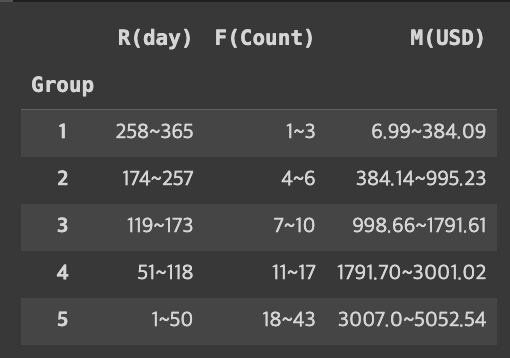

In [35]:
def customerSegmentation(row):

  if row['R'] >= 258 and row['R'] <= 365 and row['F'] >= 1 and row['F'] <= 3 and row['M'] >= 6.99 and row['M'] <= 384.09:
    return '이탈'
  elif row['R'] >= 174 and row['R'] <= 257 and row['F'] >= 4 and row['F'] <= 6 and row['M'] >= 384.14 and row['M'] <= 995.23:
    return '이탈 우려'
  elif row['R'] >= 119 and row['R'] <= 173 and row['F'] >= 7 and row['F'] <= 10 and row['M'] >= 998.66 and row['M'] <= 1791.61:
    return '관심 필요'
  elif row['R'] >= 51 and row['R'] <= 118 and row['F'] >= 11 and row['F'] <= 17 and row['M'] >= 1791.70 and row['M'] <= 3001.02:
    return '잠재 우량'
  elif row['R'] >= 1 and row['R'] <= 50 and row['F'] >= 18 and row['F'] <= 43 and row['M'] >= 3007.0 and row['M'] <= 5052.54:
    return '우량'
  else:
    return '기타'

In [36]:
rfm_m80_df.apply(lambda row: customerSegmentation(row), axis=1).value_counts()

기타       1009
이탈         56
우량         50
잠재 우량      21
이탈 우려      20
관심 필요      18
dtype: int64

- --> 5개 그룹 내에 포함되지 않는 고객이 1000명 이상 존재함

In [37]:
rfm_m80_df['고객 세그먼트'] = rfm_m80_df.apply(lambda row: customerSegmentation(row), axis=1)

In [38]:
rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '기타']

,CustomerID,R,F,M,RScore,MScore,FScore,RFMScore,고객 세그먼트
0,USER_0000,108,1,99.98,4,1,1,411,기타
2,USER_0002,74,8,1573.49,4,3,3,433,기타
3,USER_0003,18,11,1421.96,5,3,4,543,기타
4,USER_0004,108,13,1524.42,4,3,4,443,기타
5,USER_0005,131,3,706.02,3,2,1,312,기타
...,...,...,...,...,...,...,...,...,...
1462,USER_1462,180,2,70.85,2,1,1,211,기타
1463,USER_1463,271,3,676.73,1,2,1,112,기타
1464,USER_1464,88,19,2606.18,4,4,5,454,기타
1465,USER_1465,195,2,127.90,2,1,1,211,기타


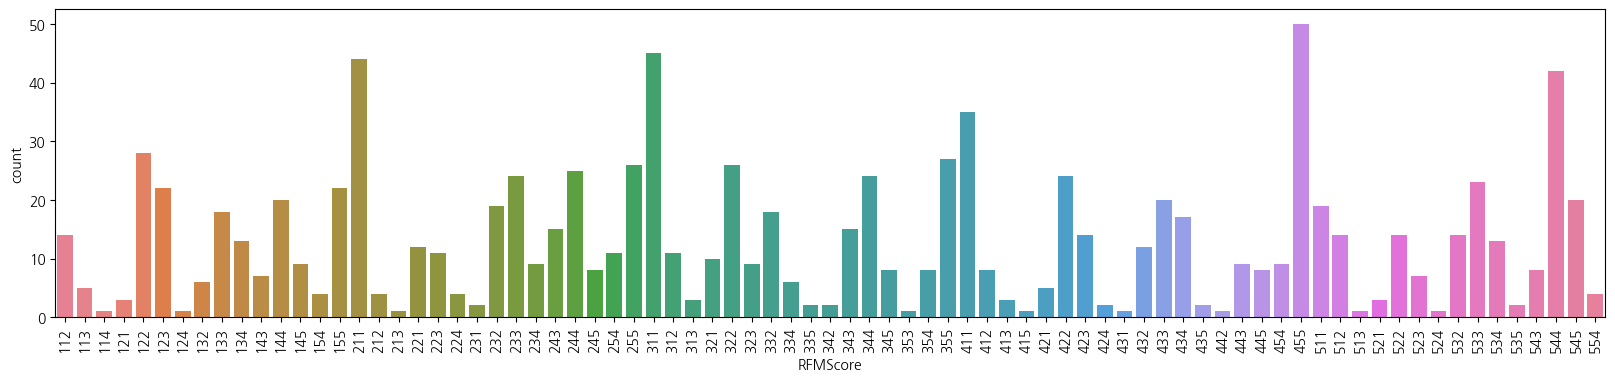

In [ ]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '기타'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

In [39]:
# '기타'인 고객들 추가적으로 분류

# R, F, M 3개가 전부 3값 이상 -> 우량
# R, F, M 중 2개가 3값 이상 -> 잠재 우량
# R, F, M 중 1개가 3값 이상 -> 관심 필요
# R, F, M 중 3개가 2값 이하 -> 이탈 우려 / 그 중 R,F이 1이면 -> 이탈

def customerSegmentationOther(row):

  if int(row['RScore']) >= 3 and int(row['FScore']) >= 3 and int(row['MScore']) >= 3:
    return '우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) >= 3 and int(row['MScore']) <= 2:
    return '잠재 우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) <= 2 and int(row['MScore']) >= 3:
    return '잠재 우량'

  elif int(row['RScore']) <= 2 and int(row['FScore']) >= 3 and int(row['MScore']) >= 3:
    return '잠재 우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) <= 2 and int(row['MScore']) <= 2:
    return '관심 필요'

  elif int(row['RScore']) <= 2 and int(row['FScore']) >= 3 and int(row['MScore']) <= 2:
    return '관심 필요'

  elif int(row['RScore']) <= 2 and int(row['FScore']) <= 2 and int(row['MScore']) >= 3:
    return '관심 필요'

  elif int(row['RScore']) <= 2 and int(row['FScore']) <= 2 and int(row['MScore']) <= 2:

    if int(row['RScore']) == 1 and int(row['FScore']) == 1:
      return '이탈'
    else:
      return '이탈 우려'

In [40]:
rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '기타'].apply(lambda row: customerSegmentationOther(row), axis=1).value_counts()

우량       318
잠재 우량    300
관심 필요    286
이탈 우려     91
이탈        14
dtype: int64

- --> 비교적 골고루 분배됨

In [41]:
rfm_m80_df['고객 세그먼트'] = rfm_m80_df.apply(lambda row: customerSegmentationOther(row) if row['고객 세그먼트'] == '기타' else row['고객 세그먼트'], axis=1)

In [42]:
rfm_m80_df['고객 세그먼트'].value_counts()

우량       368
잠재 우량    321
관심 필요    304
이탈 우려    111
이탈        70
Name: 고객 세그먼트, dtype: int64

In [43]:
rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '우량']

,CustomerID,R,F,M,RScore,MScore,FScore,RFMScore,고객 세그먼트
2,USER_0002,74,8,1573.49,4,3,3,433,우량
3,USER_0003,18,11,1421.96,5,3,4,543,우량
4,USER_0004,108,13,1524.42,4,3,4,443,우량
12,USER_0012,123,13,2343.50,3,4,4,344,우량
13,USER_0013,165,14,1562.38,3,3,4,343,우량
...,...,...,...,...,...,...,...,...,...
1451,USER_1451,109,21,2980.86,4,4,5,454,우량
1453,USER_1453,88,32,4411.48,4,5,5,455,우량
1455,USER_1455,131,11,1114.93,3,3,4,343,우량
1456,USER_1456,124,13,2718.13,3,4,4,344,우량


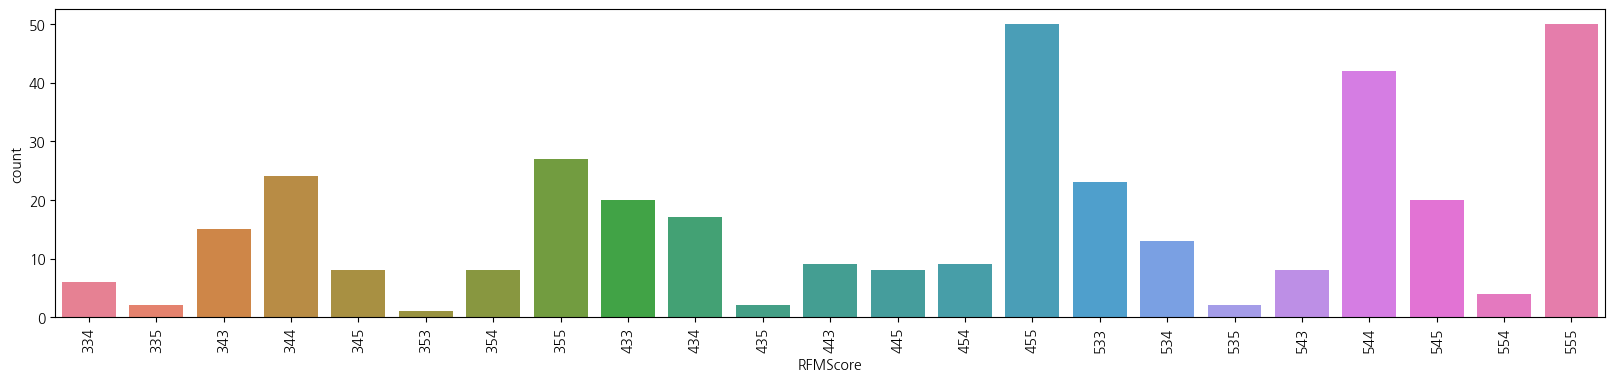

In [46]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '우량'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

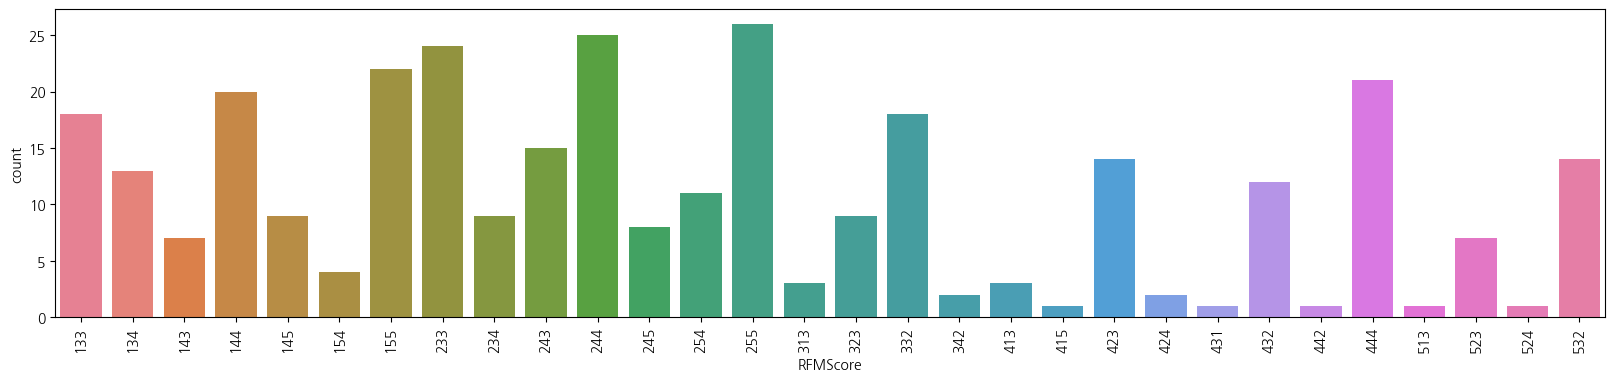

In [44]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '잠재 우량'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

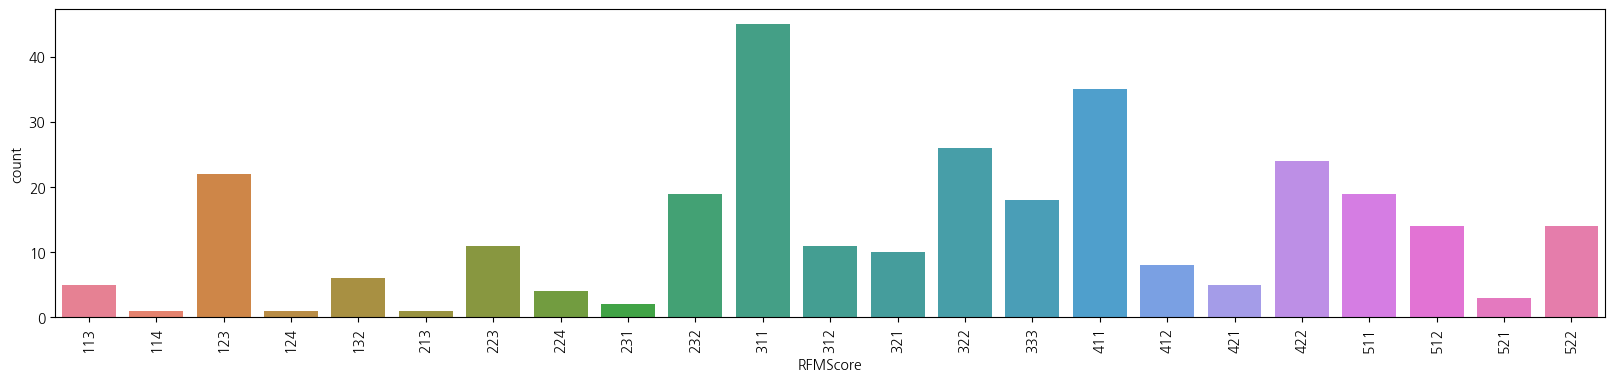

In [45]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '관심 필요'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

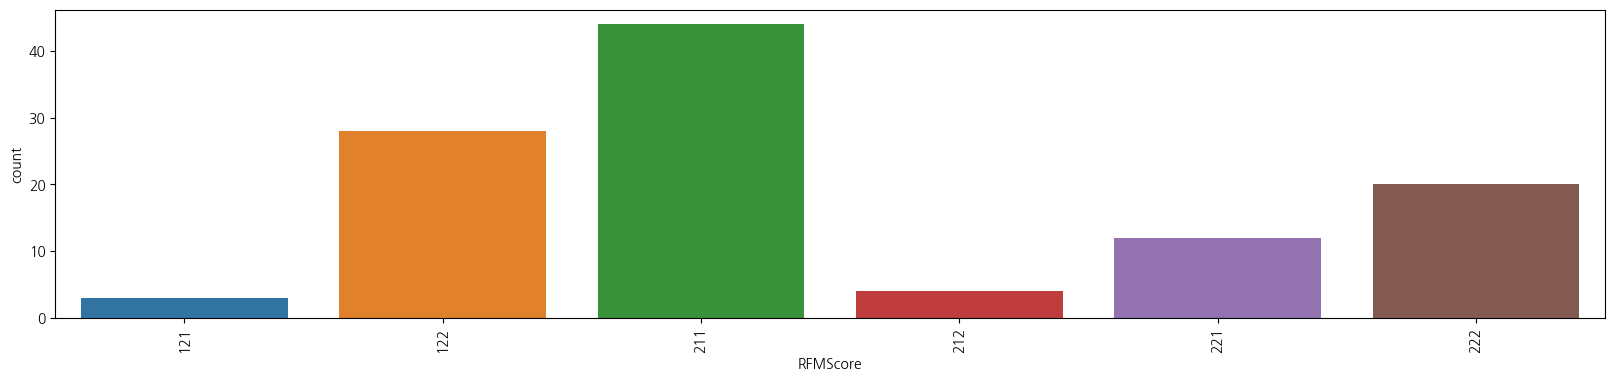

In [47]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '이탈 우려'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

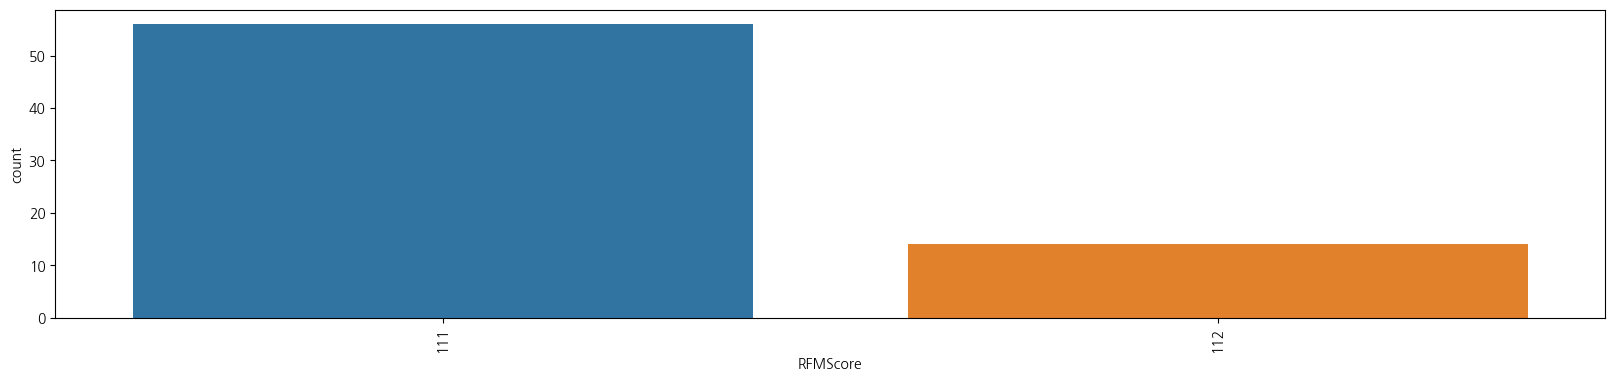

In [48]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_df[rfm_m80_df['고객 세그먼트'] == '이탈'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

- 고객 세그먼트별 인원수

In [49]:
rfm_m80_df.groupby(['고객 세그먼트'])[['CustomerID']].count().rename(columns={'CustomerID':'고객 수'}).sort_values('고객 수', ascending=False)

,고객 수
고객 세그먼트,
우량,368
잠재 우량,321
관심 필요,304
이탈 우려,111
이탈,70


In [50]:
len(set(onlinesales_info['고객ID']) - set(rfm_m80_df['CustomerID']))

294

- 인기 카테고리 확인

In [51]:
popular_category_df = pd.merge(rfm_m80_df, onlinesales_info, left_on='CustomerID', right_on='고객ID', how='left').groupby(['고객 세그먼트', '제품카테고리'])[['수량']].count().reset_index()
popular_category_df

,고객 세그먼트,제품카테고리,수량
0,관심 필요,Accessories,15
1,관심 필요,Android,1
2,관심 필요,Apparel,1134
3,관심 필요,Backpacks,5
4,관심 필요,Bags,98
...,...,...,...
82,잠재 우량,Nest-Canada,58
83,잠재 우량,Nest-USA,2146
84,잠재 우량,Notebooks & Journals,110
85,잠재 우량,Office,1059


In [52]:
# 그래프 그리기
def drawBarplot(df, segment, col1, col2):

  plt.figure(figsize=(10, 6))
  segment_data = df[df['고객 세그먼트'] == segment]
  segment_data = segment_data.sort_values(col2, ascending=False)
  plt.bar(segment_data[col1], segment_data[col2], label=segment)
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.title(f'{col1}별 판매{col2}')
  plt.xticks(rotation=45, ha='right')
  plt.legend()
  plt.show()

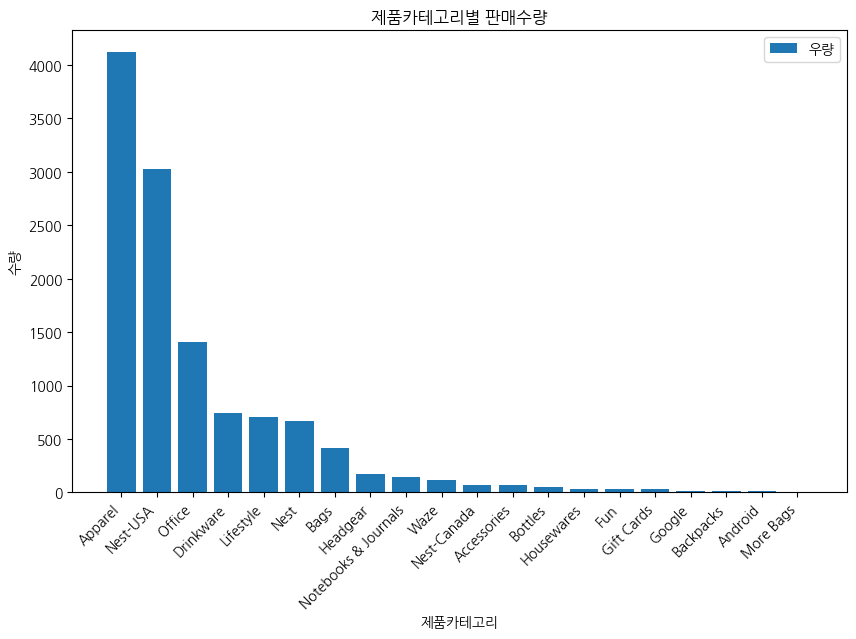

In [53]:
drawBarplot(popular_category_df, '우량', '제품카테고리', '수량')

- --> TOP3 : Nest-USA, Apparel, Office

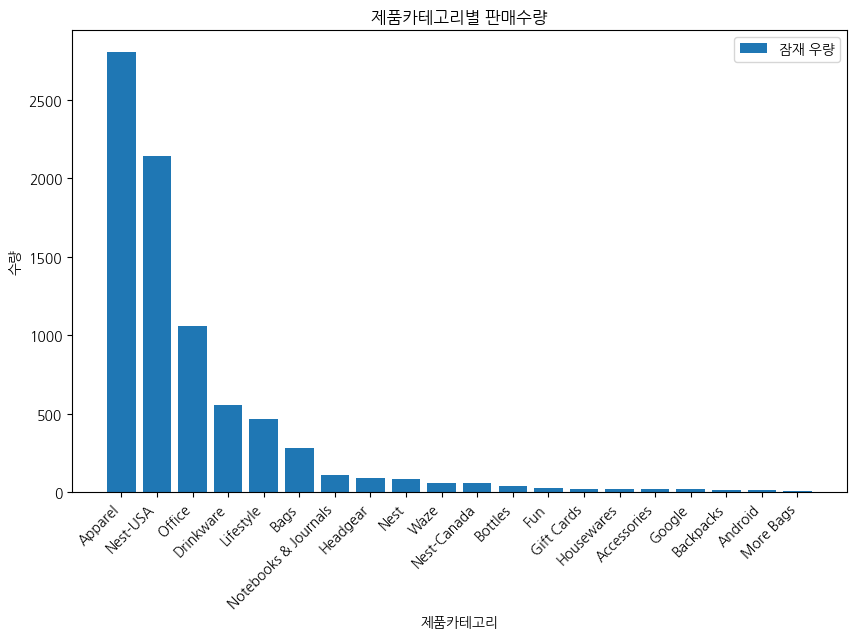

In [54]:
drawBarplot(popular_category_df, '잠재 우량', '제품카테고리', '수량')

- --> TOP3 : Apparel, Nest-USA, Office

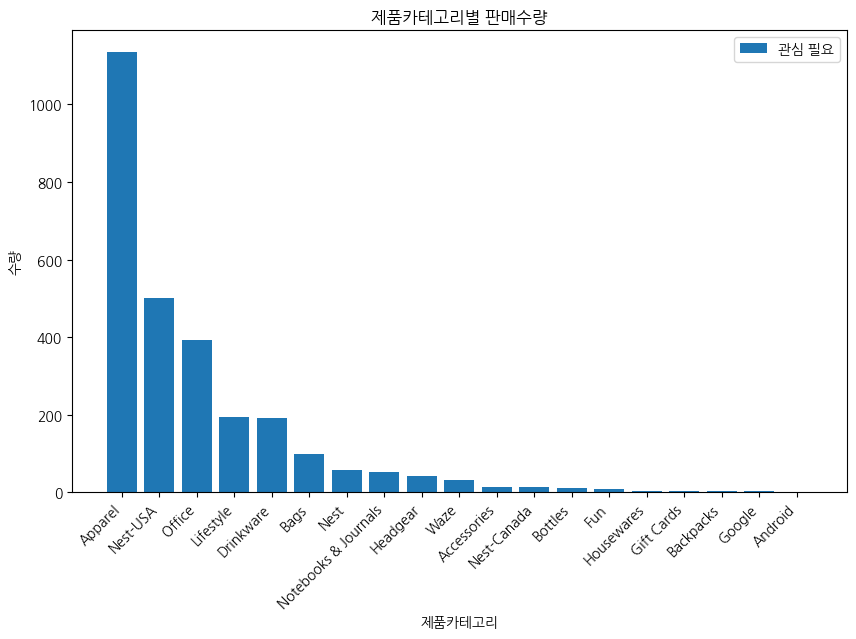

In [55]:
drawBarplot(popular_category_df, '관심 필요', '제품카테고리', '수량')

- --> TOP3 : Apparel, Nest-USA, Office

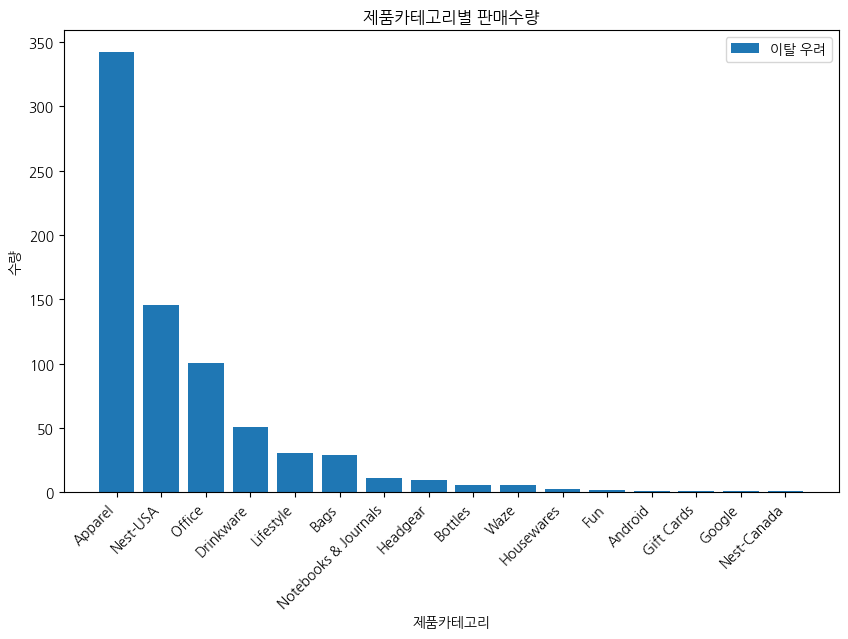

In [56]:
drawBarplot(popular_category_df, '이탈 우려', '제품카테고리', '수량')

- --> TOP3 : Apparel, Nest-USA, Office

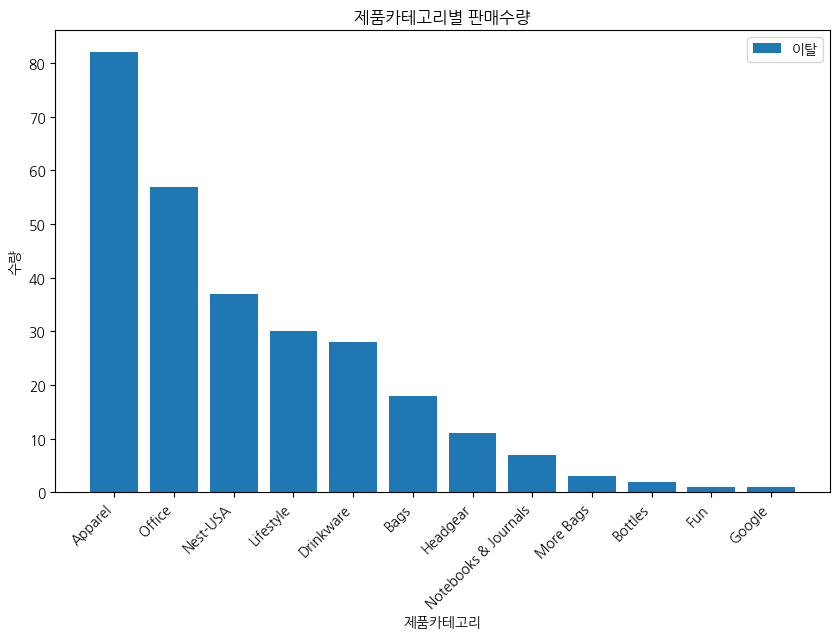

In [57]:
drawBarplot(popular_category_df, '이탈', '제품카테고리', '수량')

- --> TOP3 : Apparel, Nest-USA, Office

- --> 정리 : 모든 세그먼트에서 Apparel, Nest-USA, Office의 구매 건수가 가장 높게 나옴
  - --> Nest-USA의 경우 평균가가 높은 편에 속함에도 모든 세그먼트에서 구매 건수가 높게 잡힘

- 쿠폰 사용 비율 확인

In [60]:
rfm_m80_df.groupby(['고객 세그먼트'])[['CustomerID']].count().rename(columns={'CustomerID':'고객 수'}).sort_values('고객 수', ascending=False)

,고객 수
고객 세그먼트,
우량,368
잠재 우량,321
관심 필요,304
이탈 우려,111
이탈,70


In [58]:
tmp_df2 = pd.merge(rfm_m80_df, shoppingcart_df, left_on='CustomerID', right_on='고객ID', how='left')

In [59]:
tmp_df2.groupby(['고객 세그먼트'])[['쿠폰사용여부']].mean().rename(columns={'쿠폰사용여부':'쿠폰사용비율'})

,쿠폰사용비율
고객 세그먼트,
관심 필요,0.510518
우량,0.479019
이탈,0.470588
이탈 우려,0.466844
잠재 우량,0.472584


- --> 이탈 : 고객 수에 비해 쿠폰 사용 비율이 높음
- --> 우량 : 고객 수 대비 쿠폰 사용률은 그리 높지 않음

- 마케팅 비용 효과
  - 그룹별로 얼만큼 유입되었을지

In [ ]:
marketing_info

,날짜,오프라인비용,온라인비용
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30
...,...,...,...
360,2019-12-27,4000,3396.87
361,2019-12-28,4000,3246.84
362,2019-12-29,4000,2546.58
363,2019-12-30,4000,674.31


In [61]:
add_marketing_df_m80 = pd.merge(tmp_df2, marketing_info, left_on='거래날짜', right_on='날짜', how='left' )
add_marketing_df_m80['날짜'] = pd.to_datetime(add_marketing_df_m80['날짜'])

In [62]:
tmp_df3 = add_marketing_df_m80.groupby(['고객 세그먼트', '날짜']).agg({'총결제금액':'sum', '오프라인비용':'mean', '온라인비용':'mean'}).reset_index()
tmp_df3

,고객 세그먼트,날짜,총결제금액,오프라인비용,온라인비용
0,관심 필요,2019-01-01,175.58,4500.0,2424.50
1,관심 필요,2019-01-04,9.22,4500.0,2928.55
2,관심 필요,2019-01-05,3540.60,4500.0,4055.30
3,관심 필요,2019-01-07,688.60,4500.0,2579.52
4,관심 필요,2019-01-09,2904.57,5000.0,3287.83
...,...,...,...,...,...
852,잠재 우량,2019-12-18,1096.30,4500.0,663.46
853,잠재 우량,2019-12-20,152.45,4500.0,2876.39
854,잠재 우량,2019-12-21,173.57,4500.0,3112.73
855,잠재 우량,2019-12-22,786.97,4500.0,2309.46


In [63]:
tmp_df3['날짜'] = tmp_df3['날짜'].dt.strftime('%Y-%m')
tmp_df3 = tmp_df3.groupby(['고객 세그먼트', '날짜'])['총결제금액', '오프라인비용', '온라인비용'].sum().reset_index()
tmp_df3

,고객 세그먼트,날짜,총결제금액,오프라인비용,온라인비용
0,관심 필요,2019-01,24438.11,57100.0,31701.06
1,관심 필요,2019-02,4069.58,15300.0,13178.43
2,관심 필요,2019-03,13110.63,26500.0,19422.49
3,관심 필요,2019-04,21101.76,56000.0,34136.48
4,관심 필요,2019-05,13568.75,33500.0,24443.81
5,관심 필요,2019-06,18836.12,46500.0,29285.33
6,관심 필요,2019-07,14848.82,35500.0,30484.50
7,관심 필요,2019-08,33007.25,73500.0,52447.95
8,관심 필요,2019-09,11864.95,49500.0,26989.05
9,관심 필요,2019-10,12144.42,60500.0,38712.96


In [64]:
def drawGraph(df, segment, col1, col2, col3):

  df_ = df[df['고객 세그먼트'] == segment]
  plt.figure(figsize=(10, 6))

  ax1 = plt.gca()
  ax1.bar(df_['날짜'], df_[col1], color='lightblue', alpha=0.7, label='월별 매출')
  ax1.set_ylabel('월별 매출(달러)', fontsize=14)
  ax1.set_ylim([0, 200000])

  ax2 = ax1.twinx()
  ax2.plot(df_['날짜'], df_[col2], color='darkred', marker='o', label='월별 오프라인비용')
  ax2.plot(df_['날짜'], df_[col3], color='saddlebrown', marker='x', label='월별 온라인비용')
  ax2.set_ylabel('월별 마케팅비용', fontsize=14)
  ax2.set_ylim([0, 150000])

  ax1.yaxis.set_tick_params(size=0)
  ax2.yaxis.set_tick_params(size=0)
  ax1.xaxis.set_tick_params(size=0)


  ax1.spines['top'].set_visible(False)
  ax1.spines['left'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax2.spines['top'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax2.spines['right'].set_visible(False)

  lines, labels = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc='center right')

  ax1.yaxis.set_label_coords(-0.07, 0.5)
  ax2.yaxis.set_label_coords(1.07, 0.5)

  plt.title('월별 매출 & 마케팅 비용', fontsize=18)
  plt.show()

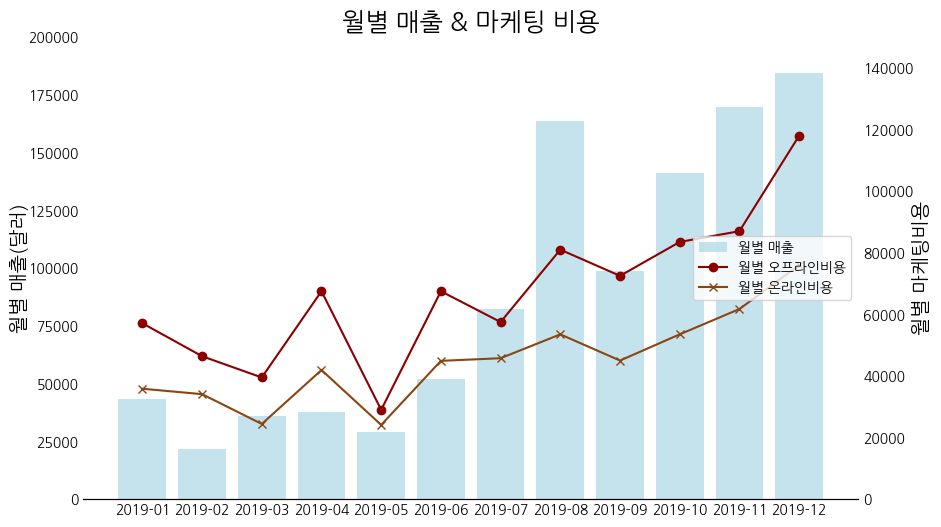

In [65]:
drawGraph(tmp_df3, '우량', '총결제금액', '오프라인비용', '온라인비용')

- --> 마케팅비용 대비 8월, 10월, 11월, 12월은 매출이 오름
- --> 3월은 전월대비 매출 상승
  - --> '우량' : 8월, 10월, 11월, 12월 중점으로 매출 더 끌어올리는 계획 필요

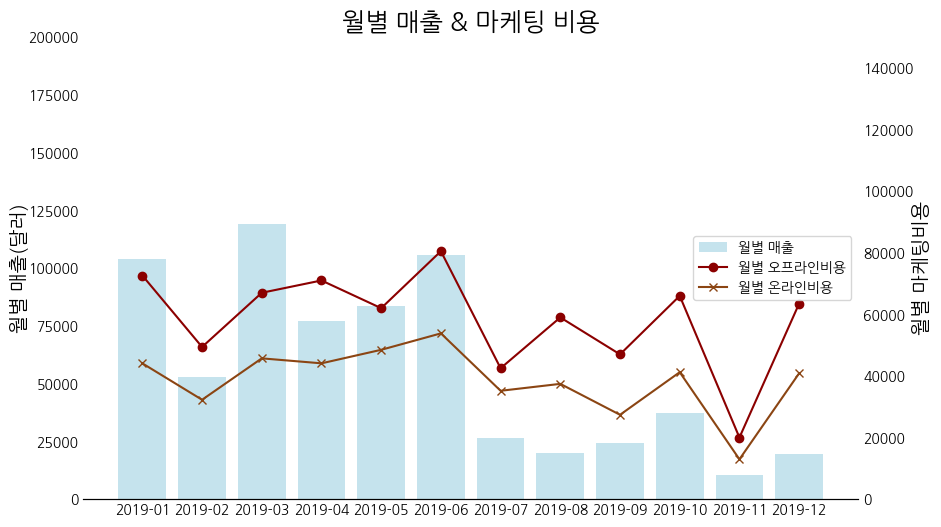

In [66]:
drawGraph(tmp_df3, '잠재 우량', '총결제금액', '오프라인비용', '온라인비용')

- --> 마케팅 비용 대비 8월은 매출이 낮음, 이에 반해 9월은 전월 대비 매출 상승함
  - --> '잠재 우량' : 9월 마케팅 비용 삭감해도 괜찮을까.?

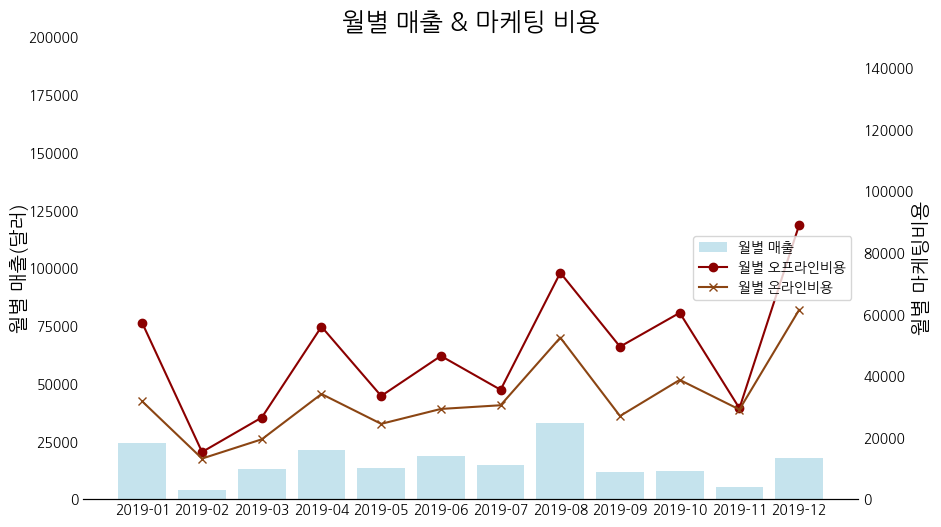

In [67]:
drawGraph(tmp_df3, '관심 필요', '총결제금액', '오프라인비용', '온라인비용')

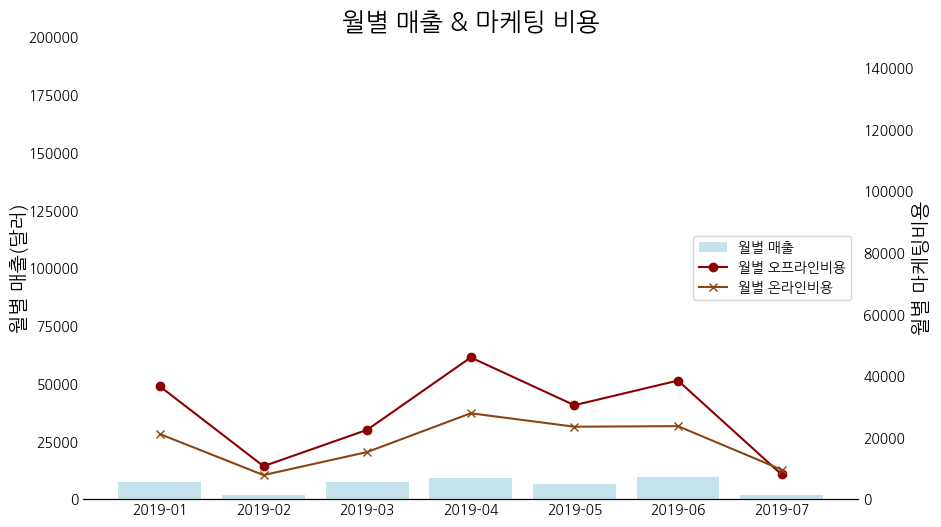

In [68]:
drawGraph(tmp_df3, '이탈 우려', '총결제금액', '오프라인비용', '온라인비용')

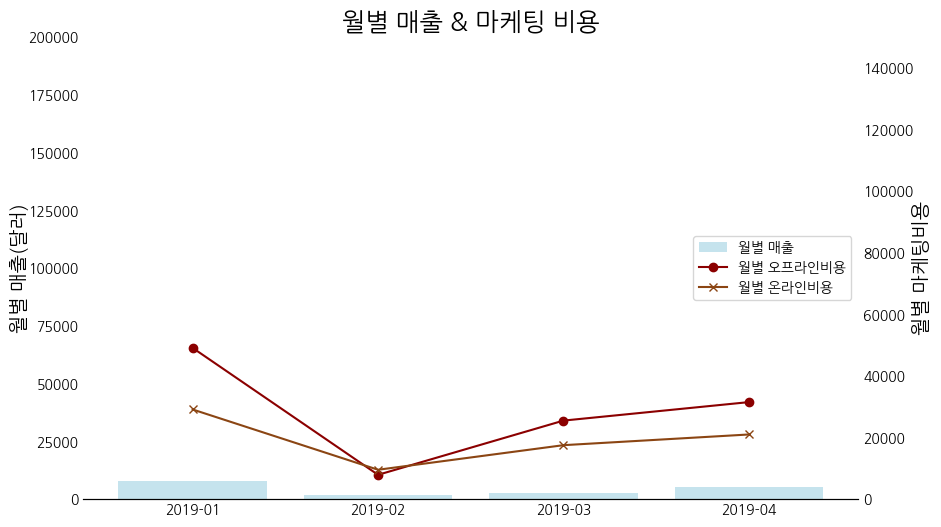

In [69]:
drawGraph(tmp_df3, '이탈', '총결제금액', '오프라인비용', '온라인비용')

- 그룹별 유입비용
  - 마케팅 비용 / 고객 수

In [70]:
segment_customer_counts = add_marketing_df_m80.groupby(['고객 세그먼트'])['고객ID'].nunique().reset_index().rename(columns={'고객ID':'고객수'})
segment_customer_counts

,고객 세그먼트,고객수
0,관심 필요,304
1,우량,368
2,이탈,70
3,이탈 우려,111
4,잠재 우량,321


In [71]:
segment_monetary = tmp_df3.groupby(['고객 세그먼트'])['총결제금액', '오프라인비용', '온라인비용'].sum().reset_index()

In [72]:
segment_monetary['마케팅비용'] = segment_monetary['오프라인비용'] + segment_monetary['온라인비용']

In [73]:
segment_monetary

,고객 세그먼트,총결제금액,오프라인비용,온라인비용,마케팅비용
0,관심 필요,190253.99,572400.0,391368.65,963768.65
1,우량,1060086.33,806500.0,540707.30,1347207.30
2,이탈,17276.66,114000.0,77166.94,191166.94
3,이탈 우려,43081.89,192800.0,128885.26,321685.26
4,잠재 우량,680390.21,700500.0,463473.38,1163973.38


In [74]:
segment_df = pd.merge(segment_customer_counts, segment_monetary, on='고객 세그먼트')
segment_df['그룹별 유입비용'] = segment_df['마케팅비용'] / segment_df['고객수']

In [75]:
segment_df

,고객 세그먼트,고객수,총결제금액,오프라인비용,온라인비용,마케팅비용,그룹별 유입비용
0,관심 필요,304,190253.99,572400.0,391368.65,963768.65,3170.291612
1,우량,368,1060086.33,806500.0,540707.30,1347207.30,3660.889402
2,이탈,70,17276.66,114000.0,77166.94,191166.94,2730.956286
3,이탈 우려,111,43081.89,192800.0,128885.26,321685.26,2898.065405
4,잠재 우량,321,680390.21,700500.0,463473.38,1163973.38,3626.085296


In [76]:
# 그래프 그리기
def drawBarplot(df, segment, col1, col2):

  plt.figure(figsize=(10, 6))
  segment_data = df[df['고객 세그먼트'] == segment]
  segment_data = segment_data.sort_values(col2, ascending=False)
  plt.bar(segment_data[col1], segment_data[col2], label=segment)
  plt.xlabel(col1)
  plt.ylabel(col2)
  plt.title(f'{col1}별 판매{col2}')
  plt.xticks(rotation=45, ha='right')
  plt.legend()
  plt.show()

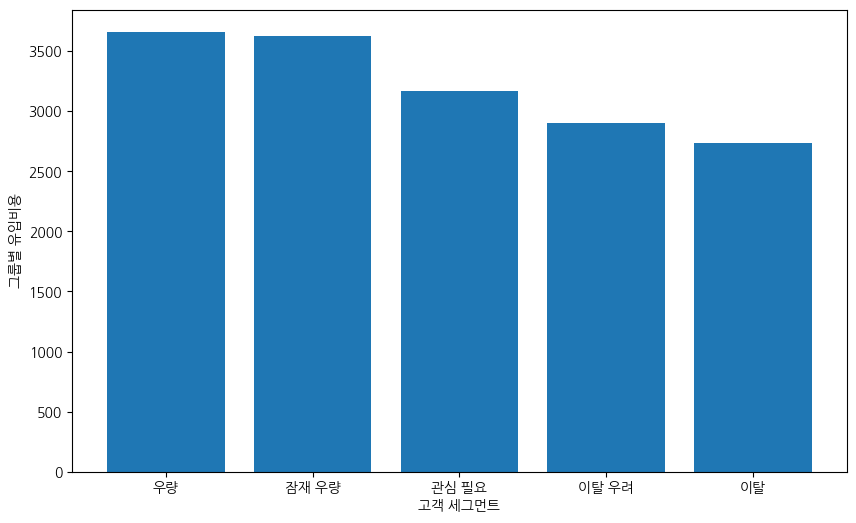

In [77]:
plt.figure(figsize=(10,6))
plt.bar(segment_df.sort_values('그룹별 유입비용', ascending=False)['고객 세그먼트'], segment_df.sort_values('그룹별 유입비용', ascending=False)['그룹별 유입비용'])
plt.xlabel('고객 세그먼트')
plt.ylabel('그룹별 유입비용');

- 고객 평균 매출

In [78]:
segment_df['그룹별 평균 매출'] = segment_df['총결제금액'] / segment_df['고객수']

In [79]:
segment_df

,고객 세그먼트,고객수,총결제금액,오프라인비용,온라인비용,마케팅비용,그룹별 유입비용,그룹별 평균 매출
0,관심 필요,304,190253.99,572400.0,391368.65,963768.65,3170.291612,625.835493
1,우량,368,1060086.33,806500.0,540707.30,1347207.30,3660.889402,2880.669375
2,이탈,70,17276.66,114000.0,77166.94,191166.94,2730.956286,246.809429
3,이탈 우려,111,43081.89,192800.0,128885.26,321685.26,2898.065405,388.125135
4,잠재 우량,321,680390.21,700500.0,463473.38,1163973.38,3626.085296,2119.595670


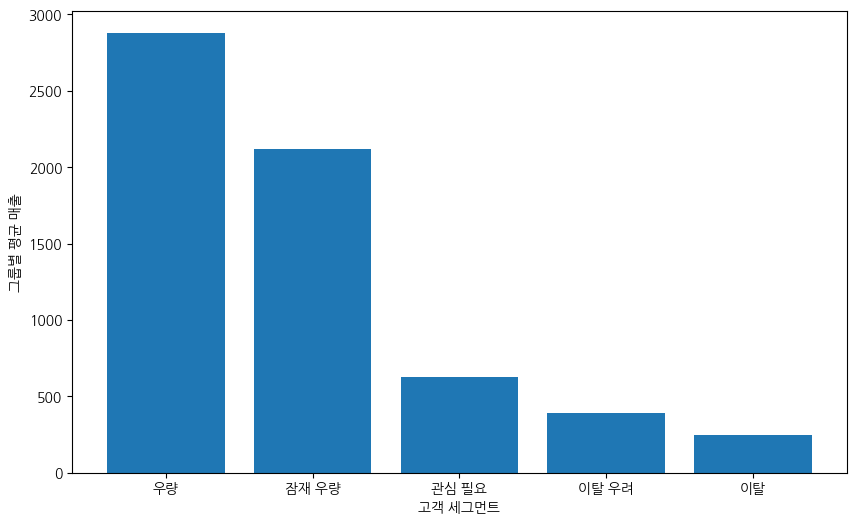

In [80]:
plt.figure(figsize=(10,6))
plt.bar(segment_df.sort_values('그룹별 유입비용', ascending=False)['고객 세그먼트'], segment_df.sort_values('그룹별 평균 매출', ascending=False)['그룹별 평균 매출'])
plt.xlabel('고객 세그먼트')
plt.ylabel('그룹별 평균 매출');

## 2-2. 상위 20% 고객 세그먼트

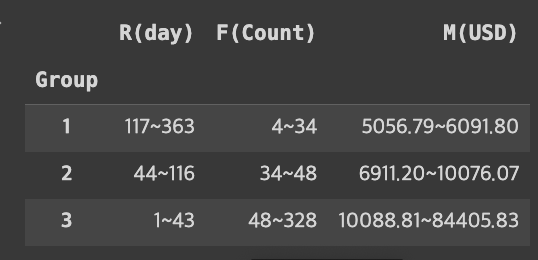

In [81]:
def customerSegmentation2(row):

  if row['R'] >= 117 and row['R'] <= 363 and row['F'] >= 4 and row['F'] <= 34 and row['M'] >= 5056.79 and row['M'] <= 6091.80:
    return '관심 필요'
  elif row['R'] >= 44 and row['R'] <= 116 and row['F'] >= 34 and row['F'] <= 48 and row['M'] >= 6911.20 and row['M'] <= 10076.07:
    return '잠재 우량'
  elif row['R'] >= 1 and row['R'] <= 43 and row['F'] >= 48 and row['F'] <= 328 and row['M'] >= 10088.81 and row['M'] <= 84405.83:
    return '우량'
  else:
    return '기타'

In [82]:
rfm_m80_upper_score_df.apply(lambda row: customerSegmentation2(row), axis=1).value_counts()

기타       225
우량        37
관심 필요     19
잠재 우량     13
dtype: int64

In [83]:
rfm_m80_upper_score_df['고객 세그먼트'] = rfm_m80_upper_score_df.apply(lambda row: customerSegmentation2(row), axis=1)

In [84]:
rfm_m80_upper_score_df[rfm_m80_upper_score_df['고객 세그먼트'] == '기타']

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore,고객 세그먼트
1,USER_0001,60,31,15308.13,2,1,3,213,기타
6,USER_0006,190,44,7708.11,1,2,2,122,기타
8,USER_0008,41,37,10807.72,3,2,3,323,기타
9,USER_0009,100,39,5572.17,2,2,1,221,기타
25,USER_0025,41,32,6091.21,3,1,1,311,기타
...,...,...,...,...,...,...,...,...,...
1433,USER_1433,107,120,21138.65,2,3,3,233,기타
1435,USER_1435,49,45,11115.44,2,2,3,223,기타
1459,USER_1459,35,27,6630.81,3,1,1,311,기타
1460,USER_1460,34,30,8267.32,3,1,2,312,기타


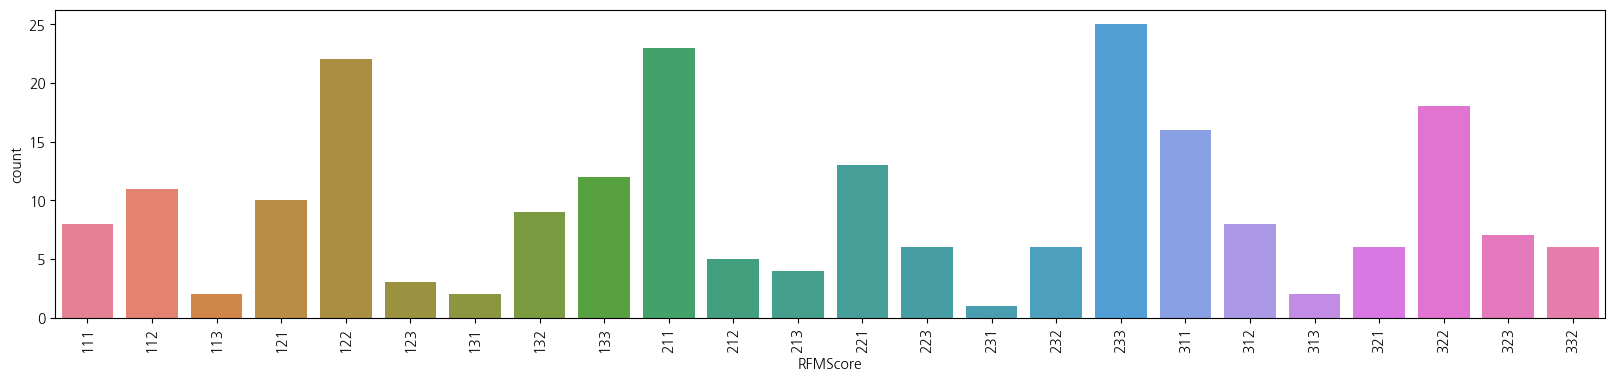

In [85]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_upper_score_df[rfm_m80_upper_score_df['고객 세그먼트'] == '기타'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

In [86]:
# '기타'인 고객들만 따로 세분화

def customerSegmentationOther2(row):

  if int(row['RScore']) >= 3 and int(row['FScore']) >= 3 and int(row['MScore']) >= 3:
    return '우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) >= 3 and int(row['MScore']) <= 2:
    return '우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) <= 2 and int(row['MScore']) >= 3:
    return '우량'

  elif int(row['RScore']) >= 3 and int(row['FScore']) <= 2 and int(row['MScore']) <= 2:
    return '잠재 우량'

  elif int(row['RScore']) <= 2 and int(row['FScore']) >= 3 and int(row['MScore']) >= 3:
    return '잠재 우량'

  elif int(row['RScore']) <= 2 and int(row['FScore']) >= 3 and int(row['MScore']) <= 2:
    return '잠재 우량'

  elif int(row['RScore']) <= 2 and int(row['FScore']) <= 2 and int(row['MScore']) >= 3:
    return '잠재 우량'

  elif int(row['RScore']) <= 2 and int(row['FScore']) <= 2 and int(row['MScore']) <= 2:
    return '관심 필요'

In [87]:
rfm_m80_upper_score_df.apply(lambda row: customerSegmentationOther2(row) if row['고객 세그먼트'] == '기타' else row['고객 세그먼트'], axis=1).value_counts()

잠재 우량    131
관심 필요    111
우량        52
dtype: int64

In [88]:
rfm_m80_upper_score_df['고객 세그먼트'] = rfm_m80_upper_score_df.apply(lambda row: customerSegmentationOther2(row) if row['고객 세그먼트'] == '기타' else row['고객 세그먼트'], axis=1)

In [89]:
rfm_m80_upper_score_df

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore,고객 세그먼트
1,USER_0001,60,31,15308.13,2,1,3,213,잠재 우량
6,USER_0006,190,44,7708.11,1,2,2,122,관심 필요
8,USER_0008,41,37,10807.72,3,2,3,323,우량
9,USER_0009,100,39,5572.17,2,2,1,221,관심 필요
25,USER_0025,41,32,6091.21,3,1,1,311,잠재 우량
...,...,...,...,...,...,...,...,...,...
1433,USER_1433,107,120,21138.65,2,3,3,233,잠재 우량
1435,USER_1435,49,45,11115.44,2,2,3,223,잠재 우량
1459,USER_1459,35,27,6630.81,3,1,1,311,잠재 우량
1460,USER_1460,34,30,8267.32,3,1,2,312,잠재 우량


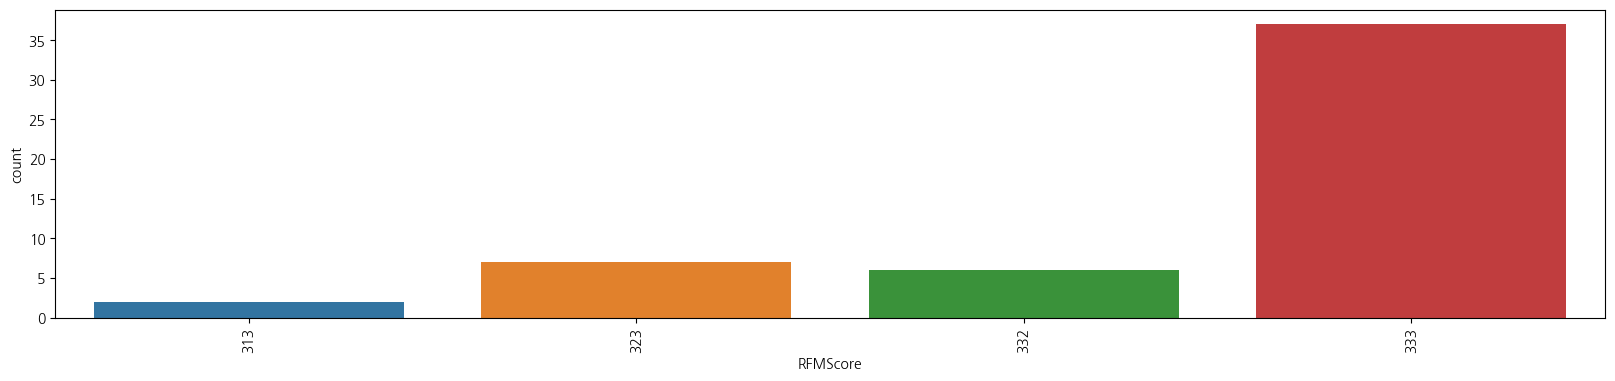

In [90]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_upper_score_df[rfm_m80_upper_score_df['고객 세그먼트'] == '우량'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

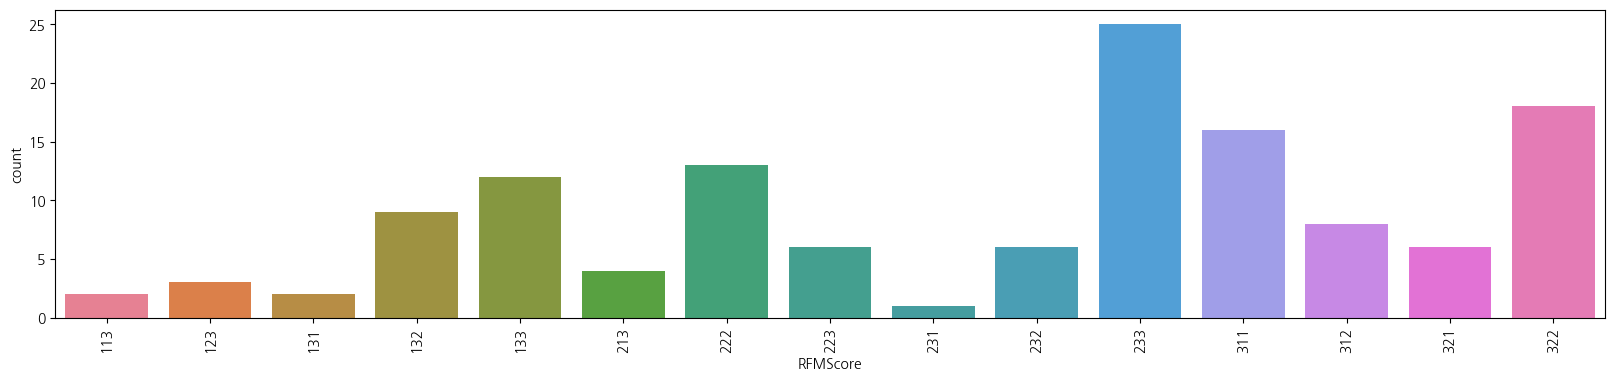

In [91]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_upper_score_df[rfm_m80_upper_score_df['고객 세그먼트'] == '잠재 우량'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

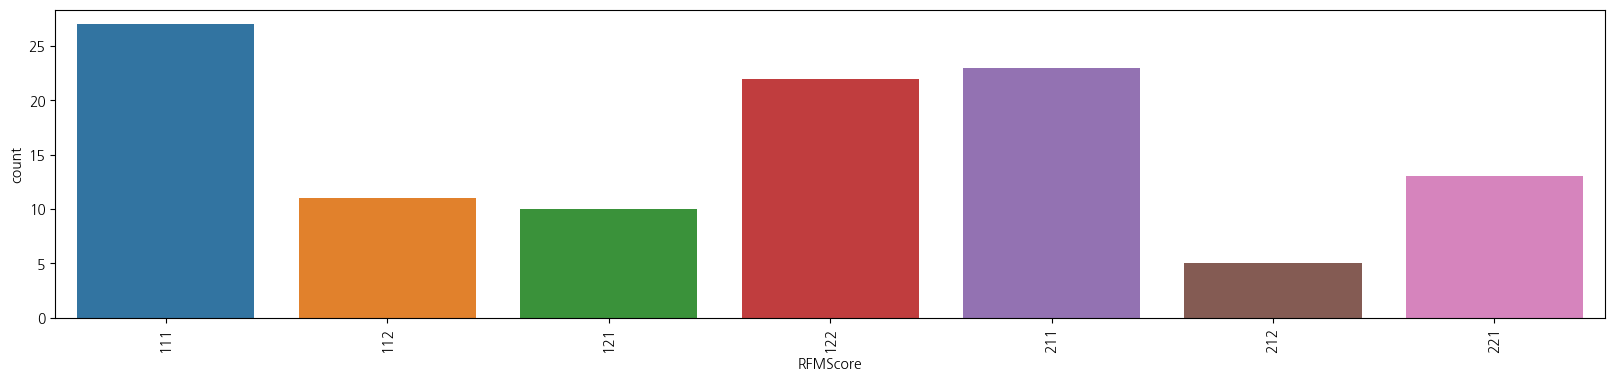

In [92]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=rfm_m80_upper_score_df[rfm_m80_upper_score_df['고객 세그먼트'] == '관심 필요'].sort_values('RFMScore'), x="RFMScore", hue = 'RFMScore');

- 고객 세그먼트별 인원수

In [93]:
rfm_m80_upper_score_df.groupby(['고객 세그먼트'])[['CustomerID']].count().rename(columns={'CustomerID':'고객 수'}).sort_values('고객 수', ascending=False)

,고객 수
고객 세그먼트,
잠재 우량,131
관심 필요,111
우량,52


- 인기 카테고리 확인

In [94]:
popular_category_df_2 = pd.merge(rfm_m80_upper_score_df, onlinesales_info, left_on='CustomerID', right_on='고객ID', how='left').groupby(['고객 세그먼트', '제품카테고리'])[['수량']].count().reset_index()
popular_category_df_2

,고객 세그먼트,제품카테고리,수량
0,관심 필요,Accessories,24
1,관심 필요,Android,7
2,관심 필요,Apparel,2206
3,관심 필요,Backpacks,14
4,관심 필요,Bags,249
5,관심 필요,Bottles,35
6,관심 필요,Drinkware,459
7,관심 필요,Fun,11
8,관심 필요,Gift Cards,9
9,관심 필요,Google,23


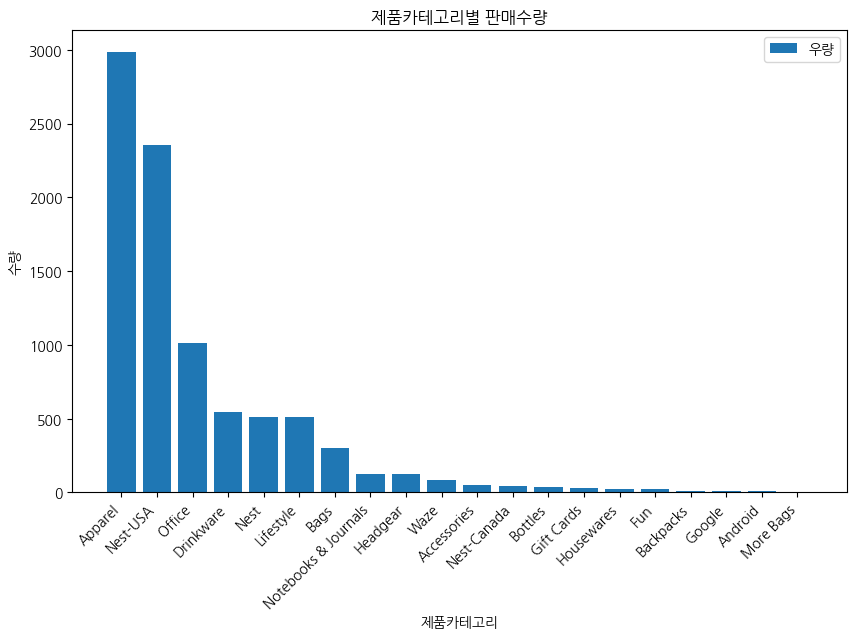

In [ ]:
drawBarplot(popular_category_df_2, '우량', '제품카테고리', '수량')

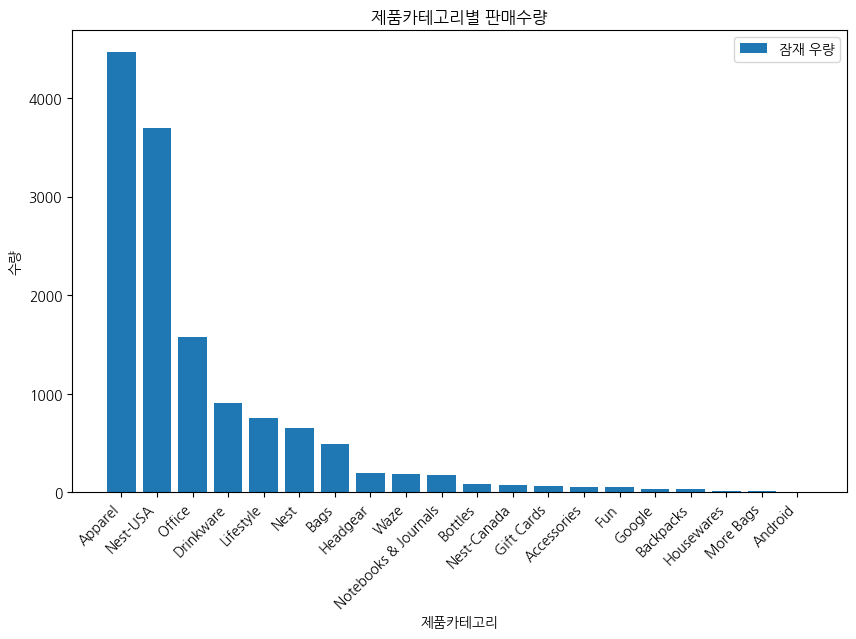

In [ ]:
drawBarplot(popular_category_df_2, '잠재 우량', '제품카테고리', '수량')

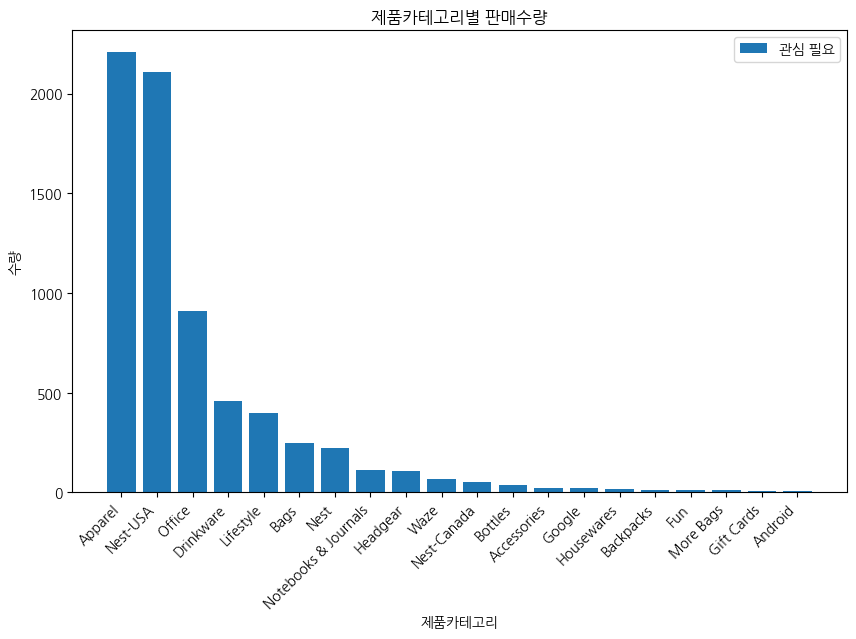

In [ ]:
drawBarplot(popular_category_df_2, '관심 필요', '제품카테고리', '수량')

- --> rfm_m80_df와 top3 제품카테고리 동일

- 쿠폰 사용 비율 확인

In [ ]:
tmp_df2_1 = pd.merge(rfm_m80_upper_score_df, shoppingcart_df, left_on='CustomerID', right_on='고객ID', how='left')

In [ ]:
tmp_df2_1.groupby(['고객 세그먼트'])[['쿠폰사용여부']].mean().rename(columns={'쿠폰사용여부':'쿠폰사용비율'})

,쿠폰사용비율
고객 세그먼트,
관심 필요,0.488627
우량,0.477114
잠재 우량,0.480692


- 마케팅 비용 효과
  - 그룹별로 얼만큼 유입되었을지

In [ ]:
add_marketing_df_m80_upper = pd.merge(tmp_df2_1, marketing_info, left_on='거래날짜', right_on='날짜', how='left' )
add_marketing_df_m80_upper['날짜'] = pd.to_datetime(add_marketing_df_m80_upper['날짜'])

In [ ]:
tmp_df3_1 = add_marketing_df_m80_upper.groupby(['고객 세그먼트', '날짜']).agg({'총결제금액':'sum', '오프라인비용':'mean', '온라인비용':'mean'}).reset_index()
tmp_df3_1

,고객 세그먼트,날짜,총결제금액,오프라인비용,온라인비용
0,관심 필요,2019-01-03,10921.51,4500.0,1576.38
1,관심 필요,2019-01-04,6054.85,4500.0,2928.55
2,관심 필요,2019-01-05,9272.80,4500.0,4055.30
3,관심 필요,2019-01-06,13768.88,4500.0,3796.85
4,관심 필요,2019-01-07,4933.72,4500.0,2579.52
...,...,...,...,...,...
702,잠재 우량,2019-12-22,7501.98,4500.0,2309.46
703,잠재 우량,2019-12-25,8247.84,4000.0,1133.70
704,잠재 우량,2019-12-26,1175.81,4000.0,1881.66
705,잠재 우량,2019-12-28,9083.81,4000.0,3246.84


In [ ]:
tmp_df3_1['날짜'] = tmp_df3_1['날짜'].dt.strftime('%Y-%m')
tmp_df3_1 = tmp_df3_1.groupby(['고객 세그먼트', '날짜'])['총결제금액', '오프라인비용', '온라인비용'].sum().reset_index()
tmp_df3_1

,고객 세그먼트,날짜,총결제금액,오프라인비용,온라인비용
0,관심 필요,2019-01,117857.28,76200.0,42149.69
1,관심 필요,2019-02,69056.76,35600.0,27439.49
2,관심 필요,2019-03,72105.62,42500.0,32193.44
3,관심 필요,2019-04,56377.42,53000.0,32472.78
4,관심 필요,2019-05,53494.87,35500.0,28093.04
5,관심 필요,2019-06,40205.16,38500.0,27816.07
6,관심 필요,2019-07,75853.21,37000.0,29485.13
7,관심 필요,2019-08,55585.85,51500.0,34186.60
8,관심 필요,2019-09,75232.03,48000.0,30020.80
9,관심 필요,2019-10,58785.36,50500.0,31826.77


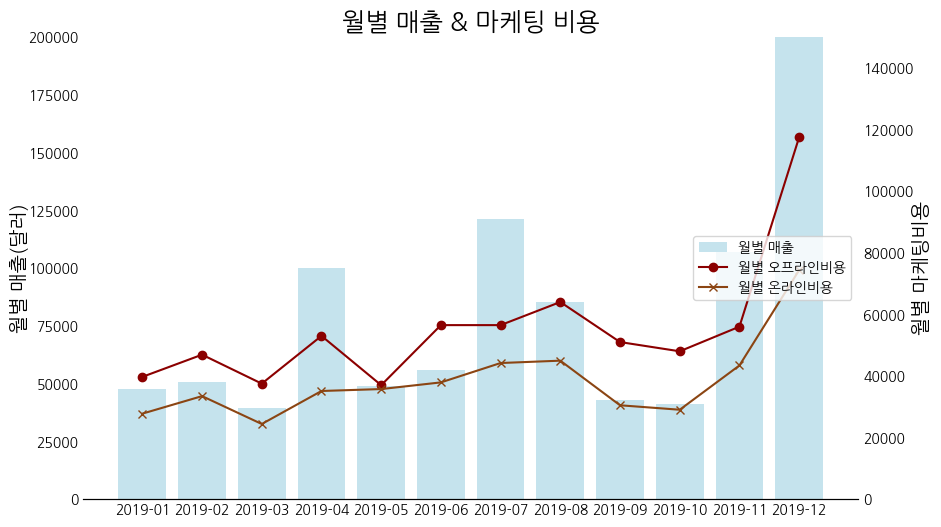

In [ ]:
drawGraph(tmp_df3_1, '우량', '총결제금액', '오프라인비용', '온라인비용')

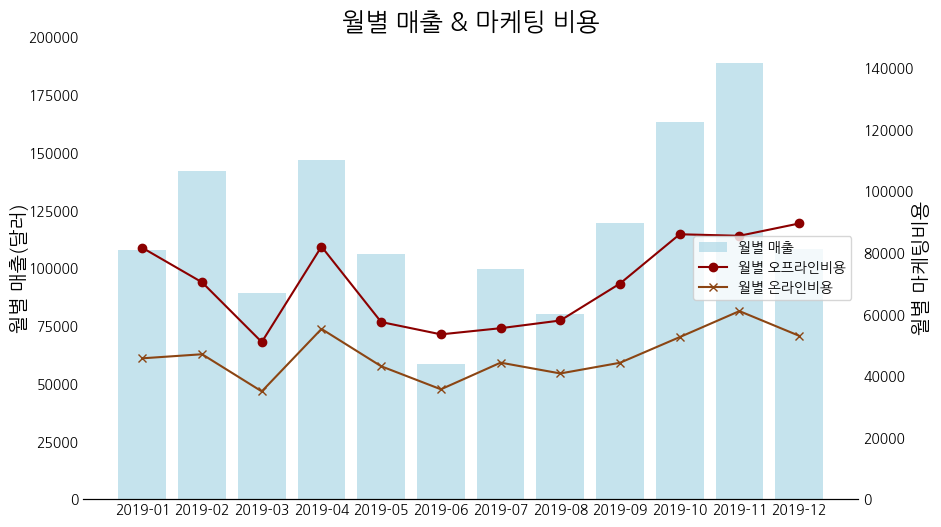

In [ ]:
drawGraph(tmp_df3_1, '잠재 우량', '총결제금액', '오프라인비용', '온라인비용')

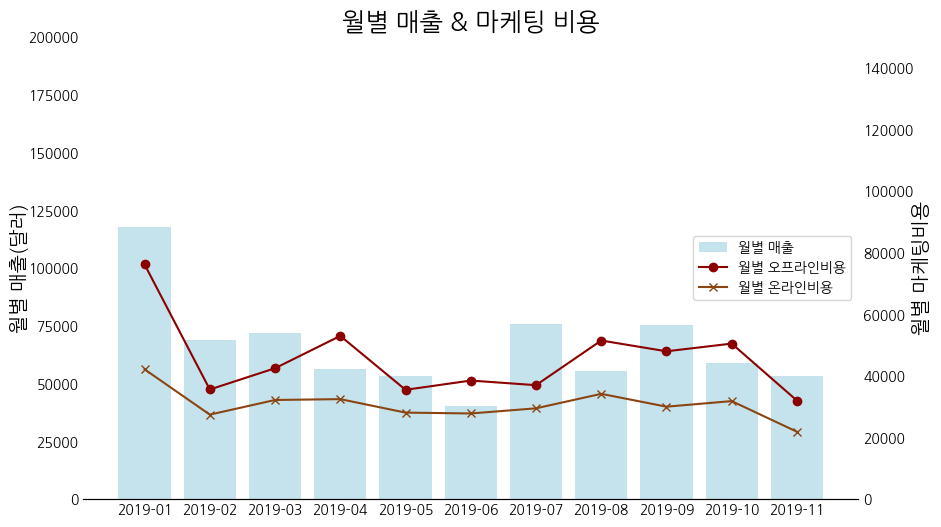

In [ ]:
drawGraph(tmp_df3_1, '관심 필요', '총결제금액', '오프라인비용', '온라인비용')

- 그룹별 유입비용
  - 마케팅 비용 / 고객 수

In [ ]:
segment_customer_counts_upper = add_marketing_df_m80_upper.groupby(['고객 세그먼트'])['고객ID'].nunique().reset_index().rename(columns={'고객ID':'고객수'})
segment_customer_counts_upper

,고객 세그먼트,고객수
0,관심 필요,111
1,우량,52
2,잠재 우량,131


In [ ]:
segment_monetary_upper = tmp_df3_1.groupby(['고객 세그먼트'])['총결제금액', '오프라인비용', '온라인비용'].sum().reset_index()
segment_monetary_upper['마케팅비용'] = segment_monetary_upper['오프라인비용'] + segment_monetary_upper['온라인비용']
segment_monetary_upper

,고객 세그먼트,총결제금액,오프라인비용,온라인비용,마케팅비용
0,관심 필요,727885.72,500300.0,337569.63,837869.63
1,우량,950088.89,663600.0,460761.73,1124361.73
2,잠재 우량,1410660.45,840500.0,557916.24,1398416.24


In [ ]:
segment_df_upper = pd.merge(segment_customer_counts_upper, segment_monetary_upper, on='고객 세그먼트')
segment_df_upper['그룹별 유입비용'] = segment_df_upper['마케팅비용'] / segment_df_upper['고객수']

In [ ]:
segment_df_upper

,고객 세그먼트,고객수,총결제금액,오프라인비용,온라인비용,마케팅비용,그룹별 유입비용
0,관심 필요,111,727885.72,500300.0,337569.63,837869.63,7548.375045
1,우량,52,950088.89,663600.0,460761.73,1124361.73,21622.340962
2,잠재 우량,131,1410660.45,840500.0,557916.24,1398416.24,10674.933130


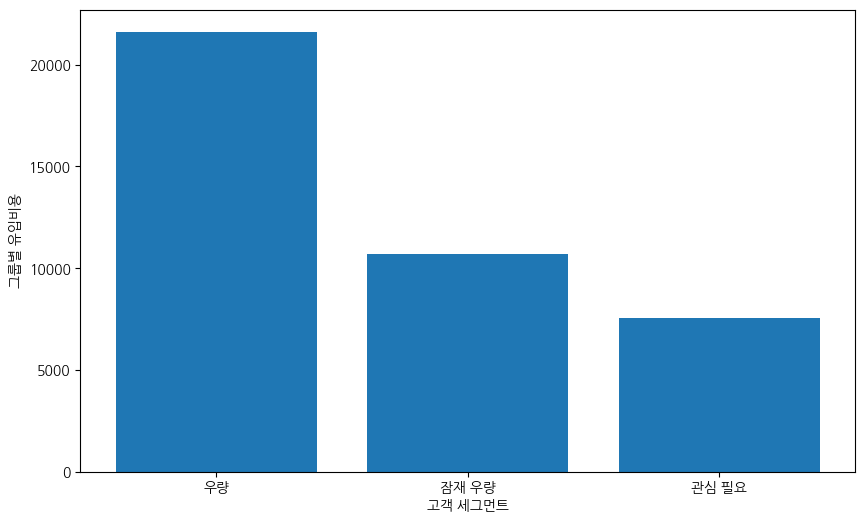

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(segment_df_upper.sort_values('그룹별 유입비용', ascending=False)['고객 세그먼트'], segment_df_upper.sort_values('그룹별 유입비용', ascending=False)['그룹별 유입비용'])
plt.xlabel('고객 세그먼트')
plt.ylabel('그룹별 유입비용');

- 고객 평균 매출

In [ ]:
segment_df_upper['그룹별 평균 매출'] = segment_df_upper['총결제금액'] / segment_df_upper['고객수']

In [ ]:
segment_df_upper

,고객 세그먼트,고객수,총결제금액,오프라인비용,온라인비용,마케팅비용,그룹별 유입비용,그룹별 평균 매출
0,관심 필요,111,727885.72,500300.0,337569.63,837869.63,7548.375045,6557.529009
1,우량,52,950088.89,663600.0,460761.73,1124361.73,21622.340962,18270.940192
2,잠재 우량,131,1410660.45,840500.0,557916.24,1398416.24,10674.933130,10768.400382


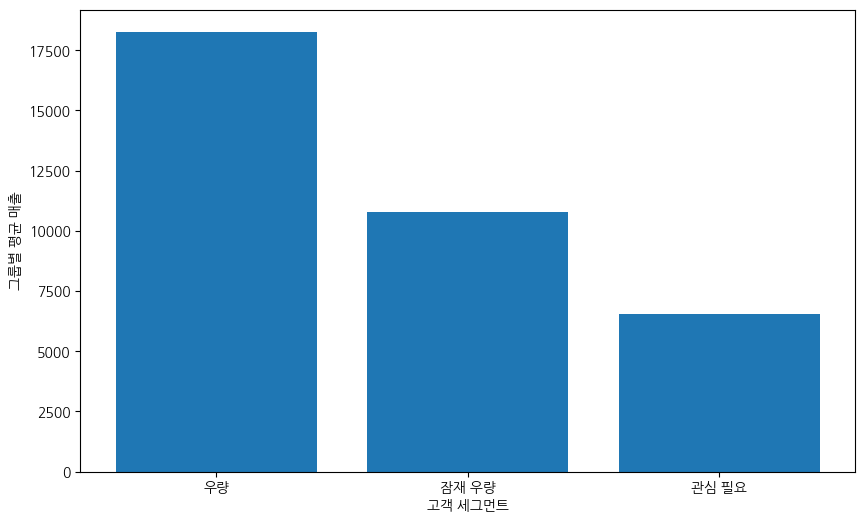

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(segment_df_upper.sort_values('그룹별 유입비용', ascending=False)['고객 세그먼트'], segment_df_upper.sort_values('그룹별 평균 매출', ascending=False)['그룹별 평균 매출'])
plt.xlabel('고객 세그먼트')
plt.ylabel('그룹별 평균 매출');